In [2]:
import gym
import gym.spaces
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

from IPython import display
from collections import deque

In [19]:
n_episodes = 100
batch_size = 32
gamma = 0.95
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [20]:
layers = []
layers.append(nn.Linear(state_size, 24))
layers.append(nn.ReLU())
layers.append(nn.Linear(24,24))
layers.append(nn.ReLU())
layers.append(nn.Linear(24, action_size))
net = nn.Sequential(*layers).double()

In [21]:
learning_rate = 0.001
epsilon_decay = 0.995
epsilon = 1.0
epsilon_min = 0.01

In [22]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [23]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [24]:
replay_memory = deque(maxlen=2000)

In [25]:
criterion = nn.MSELoss()

In [26]:
def act(state):
    global epsilon
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    state_tensor = Variable(torch.from_numpy(state))#.float()
    act_values = net(state_tensor).data.numpy()
    return np.argmax(act_values[0])

In [27]:
def remember(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))

In [28]:
p_rewards = []
def replay(batch_size):
    minibatch = random.sample(replay_memory, batch_size)
    for state, action, reward, next_state, done in minibatch:        
        optimizer.zero_grad()   # zero the gradient buffers
        output_tensor = Variable(torch.from_numpy(state))#.float()
        output = net(output_tensor)        
        target = reward
        if not done:
            next_state_tensor = Variable(torch.from_numpy(next_state))#.float()            
            target = reward + gamma * np.amax(net(next_state_tensor).data.numpy())
        state_tensor = Variable(torch.from_numpy(state))#.float()
        target_f = net(state_tensor).data.numpy()        
        target_f[0][action] = target
        
        target_f = Variable(torch.from_numpy(target_f))#.float()
        
        loss = criterion(output, target_f)        
        loss.backward()
        optimizer.step()
    global epsilon, epsilon_min, epsilon_decay
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

In [32]:
for e in range(n_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        env.render()
        action = act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        
        next_state = np.reshape(next_state, [1, state_size])
        remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            p_rewards.append(time)
            print("episode: {}/{}, score: {}, e: {:.4}".format(e, n_episodes, time, epsilon))
            break
        if len(replay_memory) > batch_size:
            replay(batch_size)
    #if e % 10 == 0:
    #    agent.save("./save/model.ckpt")
#agent.play(env, 100)

episode: 0/100, score: 231, e: 0.009986
episode: 1/100, score: 250, e: 0.009986
episode: 2/100, score: 317, e: 0.009986
episode: 3/100, score: 260, e: 0.009986
episode: 4/100, score: 51, e: 0.009986
episode: 5/100, score: 9, e: 0.009986
episode: 6/100, score: 9, e: 0.009986
episode: 7/100, score: 8, e: 0.009986
episode: 8/100, score: 8, e: 0.009986
episode: 9/100, score: 8, e: 0.009986
episode: 10/100, score: 7, e: 0.009986
episode: 11/100, score: 8, e: 0.009986
episode: 12/100, score: 8, e: 0.009986
episode: 13/100, score: 8, e: 0.009986
episode: 14/100, score: 8, e: 0.009986
episode: 15/100, score: 8, e: 0.009986
episode: 16/100, score: 8, e: 0.009986
episode: 17/100, score: 22, e: 0.009986
episode: 18/100, score: 96, e: 0.009986
episode: 19/100, score: 116, e: 0.009986
episode: 20/100, score: 122, e: 0.009986
episode: 21/100, score: 159, e: 0.009986
episode: 22/100, score: 197, e: 0.009986
episode: 23/100, score: 107, e: 0.009986
episode: 24/100, score: 210, e: 0.009986
episode: 25/

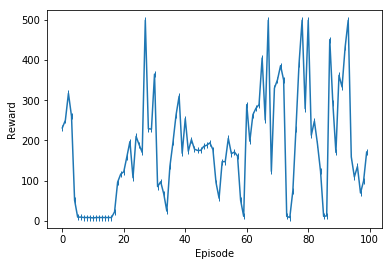

In [70]:
plt.plot(p_rewards, '-|')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()